This notebook will develop a function to read wideband frequency response output from Echoview and adjust the frequency bins to resample at a given frequency range points.

In [3]:
import csv
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import seaborn as sns
import array as arr
%matplotlib inline

In [4]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)

# Write function to read file

In [5]:
def read_scatteringmodelsimulations(fname,nsim, ve=False):
    """"Opens a file created by R for ZooScatR containing all the information of the model runs. 
    Extract the frequencies, species and cross-sectional backscatter data.
    
    Parameters:
    fname: filename with path of EV export from wideband frequency response plot - graph- export
    nsim: number of simulations
    ve: whether to use model solutions available from viscous elastic model, if species exist in 
        fname, the sigbsmean is replaced with viscous elastic mean results, else a column is added. Default False. 

    
    Returns:
    spec: array of name of species
    freqs: array of frequencies
    sigma_bs: array of cross-sectional backscatter simulation values shape is [frequencies, simulations, species]
    """
    simulations = pd.read_feather(fname)
    # Add a row for sigma_bs calculated from TS
    simulations['sigbs'] = 10**(simulations.TS/10)
    
    # Set dimensions and their values
    freqs = simulations['freq'].unique()
    specs = simulations['spec'].unique()
    
    # Allocate space
    sigma_bs_mean = np.zeros([len(freqs), len(specs)])
    #Sort values in sibgs column by species and frequencies
    simulations_group = simulations.groupby(["spec","freq"]).agg({'sigbs':lambda x: arr.array('d', x)})
    
    #for mean output
    simulations_mean = simulations.groupby(["spec","freq"]).agg({'sigbs':'mean'})
    mean_bs = simulations_mean.reset_index('freq')

    #Manually organize into an array
    for ind_spec in range(0, len(specs)):
        spec_name = specs[ind_spec]
        sim_spec = np.asarray(simulations_group.sigbs[spec_name])   
        sigma_bs_mean[:,ind_spec] = mean_bs.loc[spec_name].to_numpy()[:,1]
            
    if ve==True:
        cod_scat = pd.read_csv('../ViscousElasticModel/ve_results/ve_simulations_cod.txt', header=None, delimiter=' ', names=['frequency', 'TS'], skiprows=1)
        cod_scat['sigbs'] = 10**(cod_scat['TS']/10)
        cod_sigbs_ve = cod_scat.groupby(["frequency"]).agg({'sigbs':'mean'})
        freqs_cod = cod_scat['frequency'].unique()/1000
        
        lima_index = np.where(specs=='Limacina')
        lima_scat = pd.read_csv('../ViscousElasticModel/ve_results/ve_simulations_limacina.txt', header=None, delimiter=' ', names=['frequency', 'TS'], skiprows=1)
        lima_scat['sigbs'] = 10**(lima_scat['TS']/10)
        lima_sigbs_ve = lima_scat.groupby(["frequency"]).agg({'sigbs':'mean'})
        freqs_lima = lima_scat['frequency'].unique()/1000
        
        #resample frequency and append or replace
        f = UnivariateSpline(freqs_cod,cod_sigbs_ve, k=3, s=2)
        if (specs=='FishLarvae').any():
            cod_index=np.where(specs=='FishLarvae')
            sigma_bs_mean[:,cod_index[0][0]] = f(freqs)
        else:
            sigma_bs_mean = np.vstack((sigma_bs_mean.T,[f(freqs)]))
            sigma_bs_mean = sigma_bs_mean.T
            specs = np.append(specs,'FishLarvae')
            
        f = UnivariateSpline(freqs_lima,lima_sigbs_ve, k=5)    
        if (specs=='Limacina').any():
            lima_index = np.where(specs=='Limacina')
            sigma_bs_mean[:,lima_index[0][0]] = f(freqs)                
        else:                    
            sigma_bs_mean = np.vstack((sigma_bs_mean.T,[f(freqs)]))
            sigma_bs_mean = sigma_bs_mean.T
            specs = np.append(specs,'Limacina')            
            
                                              

    
    return specs, freqs, sigma_bs_mean

# Run function

In [12]:
fname = '../ZooScatStuff/my_simplified_data.feather'
specs, freqs, sig_mean = read_scatteringmodelsimulations(fname, nsim=1000, ve=True)

In [2]:
np.where(specs=='Copepod')

NameError: name 'np' is not defined

# Plot

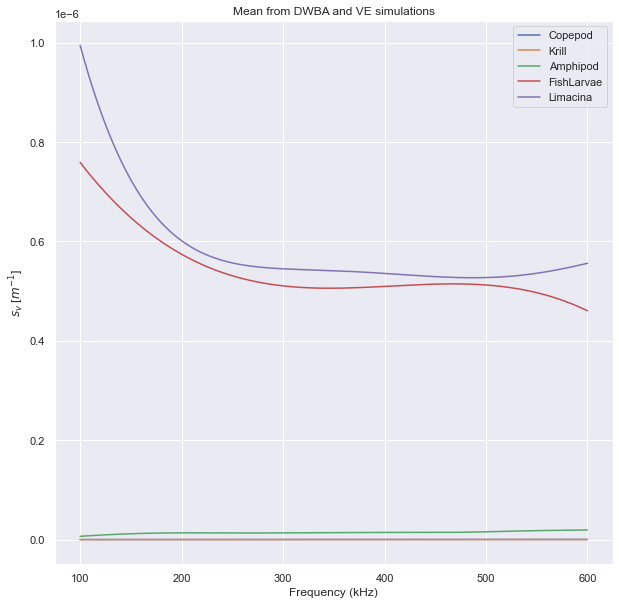

In [14]:
fig=plt.figure(figsize=(10, 10),facecolor='w', edgecolor='k')
plt.plot(freqs, sig_mean)
plt.title('Mean from DWBA and VE simulations')
plt.legend(specs)
plt.xlabel('Frequency (kHz)')
plt.ylabel('$s_{v}$ [$m^{-1}$]');

In [17]:
cod_scat = pd.read_csv('../ViscousElasticModel/ve_results/ve_simulations_cod.txt', header=None, delimiter=' ', names=['frequency', 'TS'], skiprows=1)
cod_sigbs_ve = 10**(cod_scat['TS']/10)
freqs_cod = cod_scat['frequency'].unique()/1000

In [19]:
f = UnivariateSpline(freqs_cod,cod_sigbs_ve, k=3, s=2)

ValueError: x and y should have a same length

In [21]:
np.shape(cod_sigbs_ve)

(1000000,)